[Jump to where I left off](#contd)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
%matplotlib inline

In [4]:
ar.__version__, pm.__version__, np.__version__

('0.4.0', '3.6', '1.15.4')

In [19]:
# stickbreaking is the default transform
with pm.Model() as test_stickbreaking:
    alphas = np.ones((12))
    p = pm.Dirichlet('p', a = alphas, shape = (12))
    trace_stickbreaking = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1224.77draws/s]


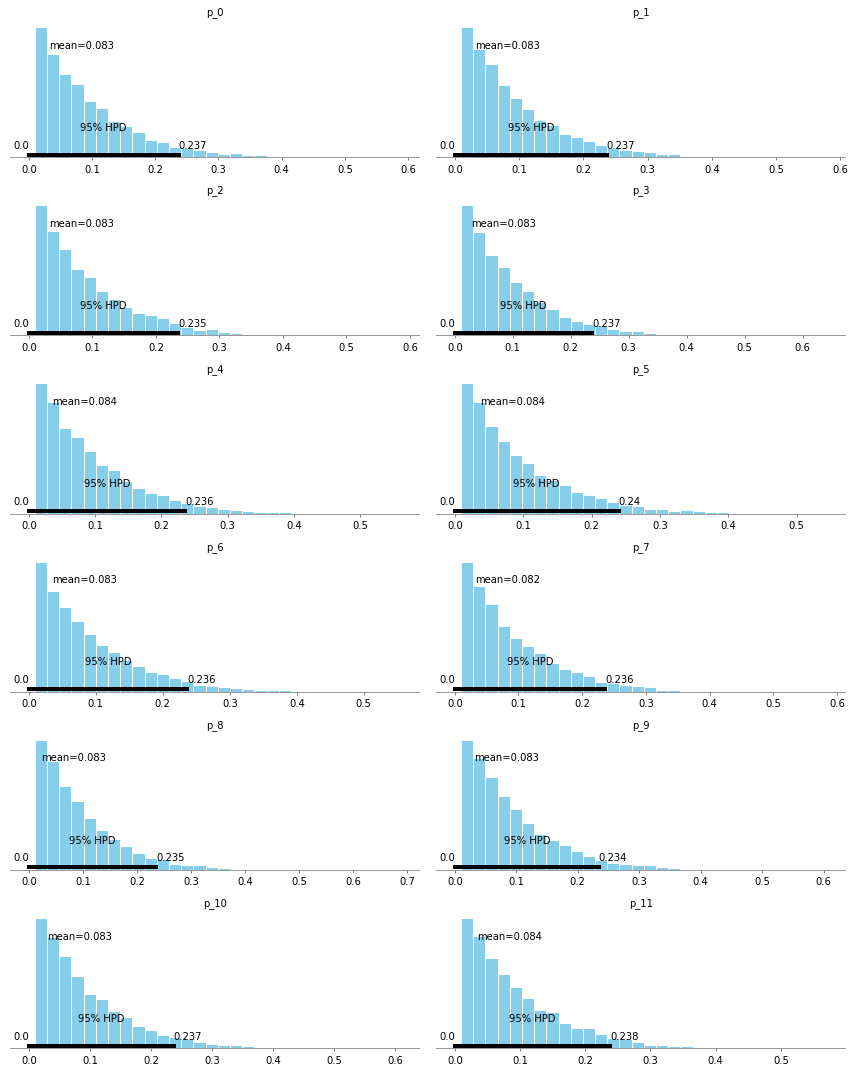

In [20]:
pm.plot_posterior(trace_stickbreaking);

In [22]:
0.083*12

0.996

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In this notebook, I implement the chlorophyll algorithms discussed earlier using a Bayesian framework, which will allow inter-model predictive skill comparison using Information Theory. For each model, implementation follows the sequence below:

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation;
* Inter-model comparisons of model skill are conducted using Information Criteria (IC) including Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave One Out Cross Validation (LOO). This step 

In [3]:
df_log = pd.read_pickle('./pickleJar/df_log_nopurple_nored_with_MBR.pkl')

In [4]:
df_log.head()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,MaxBlueBand,MaxBlueBandIdx,log_mxBlue2Gr,log_chlor_a,is_hplc
0,1565,-2.773122,-2.482397,-2.394012,-2.126145,Rrs510,2,-0.267867,1.581950,False
1,1566,-2.858857,-2.662956,-2.602191,-2.381734,Rrs510,2,-0.220457,1.544192,False
2,1567,-2.926105,-2.734427,-2.640597,-2.372060,Rrs510,2,-0.268537,1.429914,False
3,1568,-2.759143,-2.541014,-2.436014,-2.156039,Rrs510,2,-0.279976,1.680879,False
4,1559,-2.990409,-2.822196,-2.720468,-2.552735,Rrs510,2,-0.167733,1.371991,False


In [5]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 10 columns):
id                4459 non-null int64
log_rrs443        4456 non-null float64
log_rrs489        4422 non-null float64
log_rrs510        3435 non-null float64
log_rrs555        3255 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
log_mxBlue2Gr     3255 non-null float64
log_chlor_a       4127 non-null float64
is_hplc           4459 non-null bool
dtypes: bool(1), float64(6), int64(1), int8(1), object(1)
memory usage: 287.5+ KB


In [6]:
df_log_small = df_log[['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']].dropna()
X_ = df_log_small.log_mxBlue2Gr.values
y = df_log_small.log_chlor_a.values
X_poly = np.c_[X_, np.power(X_, 2), np.power(X_, 3), np.power(X_, 4)]


In [75]:
X_poly_s = (X_poly - X_poly.mean(axis=0)) / X_poly.std(axis=0)

In [7]:
X_poly.shape,

(2972, 4)

In [79]:
# Get grouping index
mbr_group_idx = df_log_small.MaxBlueBandIdx.values
n_groups = np.unique(mbr_group_idx).size
X_polyT = X_poly.T
X_poly_s_T = X_poly_s.T

## 2. Simple band ratio
   Here I use the same input as OC4, but use only the first term (power 1), in effect converting the polynomial regression to a single-term linear regression. Again two version are explored; a pooled model, and a partially pooled hierarchical model.

### 2-A. Pooled Model

In [45]:
with pm.Model() as mbr_linear_pooled:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Exponential('σ', 1)
    μ = α + β * X_
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y)

In [46]:
render_lin_pld = pm.model_to_graphviz(mbr_linear_pooled)
render_lin_pld.format = 'png'
render_lin_pld.render('mbr_linear_pooled', directory='./figJar')

'./figJar/mbr_linear_pooled.png'

<img src='./figJar/mbr_linear_pooled.png'/>

In [48]:
with mbr_linear_pooled:
    pm.sample(tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1179.63draws/s]


    B. Partially Pooled Model

In [64]:
X_s = (X_ - X_.mean()) / X_.std()
y_s = (y - y.mean()) / y.std()

In [68]:
with pm.Model() as mbr_linear_partpooled:
    hyp_α_μ = pm.Normal('hyp_α_μ', 0, 1)
    hyp_α_σ = pm.HalfCauchy('hyp_α_σ', 2.5)
    hyp_β_μ = pm.Normal('hyp_β_μ', 0, 1)
    hyp_β_σ = pm.HalfCauchy('hyp_β_σ', 2.5)
    
#     un-centered parameterization
#     α_offset = pm.Normal('α_offset', mu=0, sd=1, shape=3)
#     β_offset = pm.Normal('β_offset', mu=0, sd=1, shape=3)
#     α = pm.Deterministic('α', α_offset + hyp_α_μ * hyp_α_σ)
#     β = pm.Deterministic('β', β_offset + hyp_β_μ * hyp_β_σ)
    #--%<---------------------------------------------------
    #centered parameterization
    α = pm.Normal('α', mu=hyp_α_μ, sd=hyp_α_σ, shape=3)
    β = pm.Normal('β', mu=hyp_β_μ, sd=hyp_β_σ, shape=3)
    #--%<---------------------------------------------------
    σ = pm.Exponential('σ', 1)
    μ = α[mbr_group_idx] + β[mbr_group_idx] * X_s
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y_s)

In [52]:
render_mlpp = pm.model_to_graphviz(mbr_linear_partpooled)
render_mlpp.format='png'
render_mlpp.render('mbr_linear_partpooled', directory='./figJar')

'./figJar/mbr_linear_partpooled.png'

<img src='./figJar/mbr_linear_partpooled.png'/>

In [69]:
with mbr_linear_partpooled:
    trace_lpp = pm.sample(draws=2000, tune=1500, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α, hyp_β_σ, hyp_β_μ, hyp_α_σ, hyp_α_μ]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:42<00:00, 163.18draws/s]


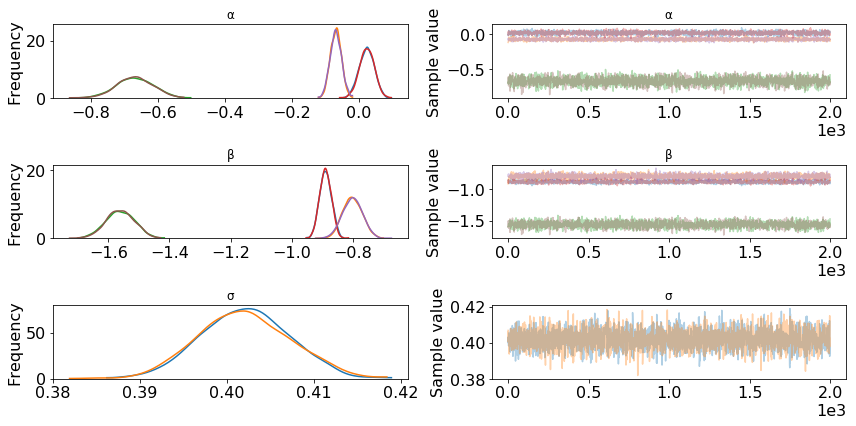

In [72]:
pm.traceplot(trace_lpp, varnames=['α', 'β', 'σ']);

4. Multivariate Linear Regression


    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

5. Multivariate Linear Regression with Prior Transformation of Principal Components of Reflectance

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error